In [1]:
%matplotlib inline
#import pymc3 as pm
#from pymc3.ode import DifferentialEquation
import numpy as np
import scipy.optimize as optimization
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib
#import arviz as az
#import theano
import ODE_models
import pandas as pd
import scipy.integrate as integrate
from scipy.integrate import quad
plt.style.use('seaborn-darkgrid')

In [2]:

r_newyorkTSV = '../../newyork.tsv'
w_newyorkTSV = '../../newyork.tsv'
tsv_readny = pd.read_csv("newyork.tsv", sep='\t')
cumulativeny = tsv_readny['confirmed'] #is this what I want?


In [3]:
recovery_days = 7 # average length of infection (current baseline from 2012)
gamma= 0.27974604 # rate of recovery

beta_S=0.2563797 # infection rate for symptomatic infectives
beta_A=0.37012359 # infection rate for asymptomatic infectives

q = .80209   # reduction factor for those with altered/adjusted behavior
p = 2/3   # probability of developing symptoms

   # average length of memory regarding active cases
nu=0.23588745  # rate of forgetting past "new case" counts

M_thresh = 0.01 # risk threshold 
m = 1/M_thresh

rho=15.19878828 # speed of behavioral changes (1/days)

mu = 10**(-8)  # irrational exploration with fixed units


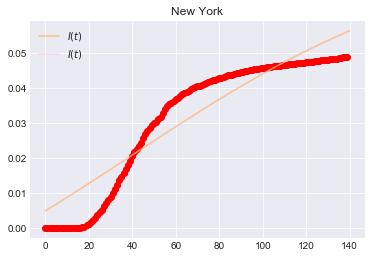

In [4]:
params = ODE_models.get_params(beta_S=0.07641291, beta_A= 0.45767813, gamma= 0.2201679,nu=0.10223429, rho=2.0525167, q=  0.35182442,p= 0.60957564)
## Set initial conditions
Nny= 8.399e6
yobsny = cumulativeny/Nny
#Sn_0ny  = 1-(0.005+yobsny[0])
#Sa_0  = 0.005
#IS_0ny  = yobsny[0]
Sn_0ny = .99
Sa_0  =  .005
IS_0ny  = .005
IAn_0 = 0
IAa_0 = 0
RS_0  = 0
RAn_0 = 0
RAa_0 = 0
M_0   = 0.01

#newyork
initial_stateny = np.array([Sn_0ny,Sa_0,IS_0ny,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
timeny = np.arange(0,140,.001)
timeobsny = np.arange(0,140,1)
sim_systemny = odeint(ODE_models.SIRan_system, initial_stateny, timeny, args=(params,))



yny =1-(sim_systemny[:,0]+sim_systemny[:,1])

ypred = np.zeros(140)
for i in range(0,140):
    ind = np.where(timeny ==i)
    ypred[i] = yny[ind]


plt.plot(timeobsny,yobsny, color= 'red',marker='o', linestyle='none')
plt.plot(timeny, yny, color='orange', alpha=0.5, label=f'$I(t)$')
plt.plot(timeobsny, ypred, color='pink', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.title('New York')
plt.show()



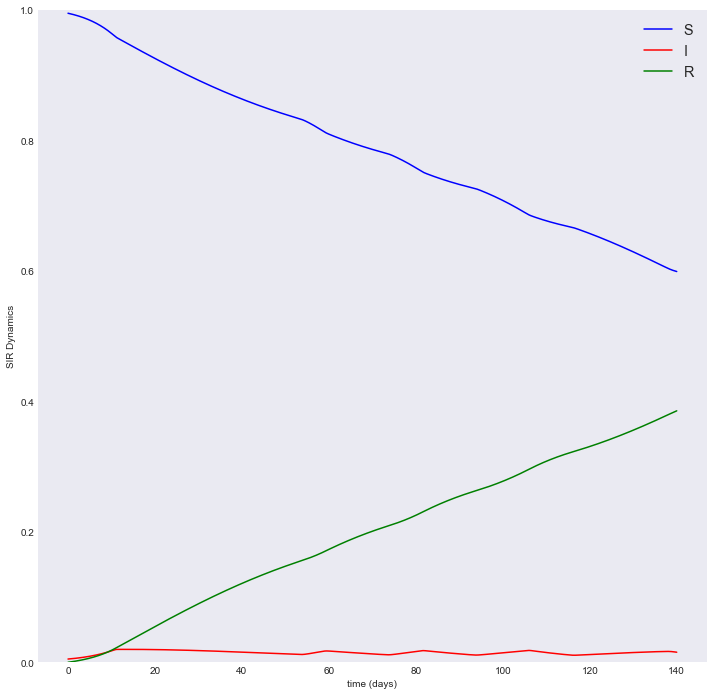

In [5]:
## Plot combined S, I, and R compartments. I have plugged in the estiamtes for rho and nu found uisng the least squares estimate 
params = ODE_models.get_params(beta_S=0.29998943, beta_A=0.36045797, gamma= 0.18561062,nu=0.16060246, rho=20.85949009, q=   0.69620799,p= 0.60070781)
fin_time = 140

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

sim_system = odeint(ODE_models.SIRan_system,initial_stateny, timeny, args=(params,))

S = sim_system[:,0]+sim_system[:,1]
I = sim_system[:,2]+sim_system[:,3]+sim_system[:,4]
R = sim_system[:,5]+sim_system[:,6]+sim_system[:,7]

S_curve, = ax.plot(timeny, S, '-b')
I_curve, = ax.plot(timeny, I, '-r')
R_curve, = ax.plot(timeny, R, '-g')

ax.set(xlabel='time (days)', ylabel='SIR Dynamics')
ax.set_ylim((0,1))
#ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((S_curve,I_curve,R_curve),('S','I','R'),loc='best',fontsize='x-large')

In [6]:
#This is where the least squares is claculated for New York
def SEfunc(params):
    nu=params[3]
    rho = params[4]
    beta_S=params[0]
    beta_A = params[1]
    gamma= params[2]
    q = params[5]
    p = params[6]
    og_params = ODE_models.get_params(beta_S=beta_S, beta_A= beta_A, gamma=gamma, nu = nu, rho=rho, q = q, p =p)
    yobsny = np.array(cumulativeny/Nny)
    ## Set initial conditions
    #Sn_0ny  = 1-(0.005+yobsny[0])
    #Sa_0  = 0.005
    #IS_0ny  = yobsny[0]
    Sn_0ny = .99
    Sa_0  =  .005
    IS_0ny  = .005
    IAn_0 = 0
    IAa_0 = 0
    RS_0  = 0
    RAn_0 = 0
    RAa_0 = 0
    M_0   = 0.01


   
    initial_stateny = np.array([Sn_0ny,Sa_0,IS_0ny,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
    timeny = np.arange(0,140,.001)
    timeobsny = np.arange(0,140,1)
    sim_systemny = odeint(ODE_models.SIRan_system, initial_stateny, timeny, args=(og_params,))
    yny =1-(sim_systemny[:,0]+sim_systemny[:,1])
    
    ypred = np.zeros(140)
    for i in range(0,140):
        ind = np.where(timeny ==i)
        ypred[i] = yny[ind]
    
    SE = (ypred-yobsny)**2
    sumSE = sum(SE)
    return((ypred-yobsny)**2)
x0 = np.array([.31, .37, 1/7, 1/7,10, 0.8, 2/3])

result= optimization.least_squares(SEfunc, x0, bounds=(np.array([0,0,0,0,0,0,0]),np.array([1,1,1,1,np.inf,1,1])))

#output is an array of the two optimal values, and then the value of the cost function at those values. 
print(result)

 active_mask: array([0, 0, 0, 0, 0, 0, 0])
        cost: 0.6573757575254295
         fun: array([2.49988094e-05, 4.12713135e-05, 6.46883691e-05, 9.76228821e-05,
       1.43175994e-04, 2.05306644e-04, 2.89074996e-04, 4.01229618e-04,
       5.49902235e-04, 7.45697141e-04, 1.00106221e-03, 1.31293043e-03,
       1.61504734e-03, 1.94137918e-03, 2.31039205e-03, 2.72352572e-03,
       3.18209307e-03, 3.68307363e-03, 4.22501648e-03, 4.80168634e-03,
       5.42758908e-03, 6.08122598e-03, 6.77335633e-03, 7.54074238e-03,
       8.31213489e-03, 9.17420041e-03, 1.01044209e-02, 1.10217267e-02,
       1.20631811e-02, 1.31302568e-02, 1.42320350e-02, 1.54110344e-02,
       1.66263029e-02, 1.78590400e-02, 1.90839428e-02, 2.05010159e-02,
       2.19353504e-02, 2.34602494e-02, 2.49927218e-02, 2.65282079e-02,
       2.81065559e-02, 2.97519351e-02, 3.15094024e-02, 3.33886804e-02,
       3.52703255e-02, 3.69868573e-02, 3.88704786e-02, 4.08302476e-02,
       4.28254086e-02, 4.48911607e-02, 4.70411918e-02, 4.9

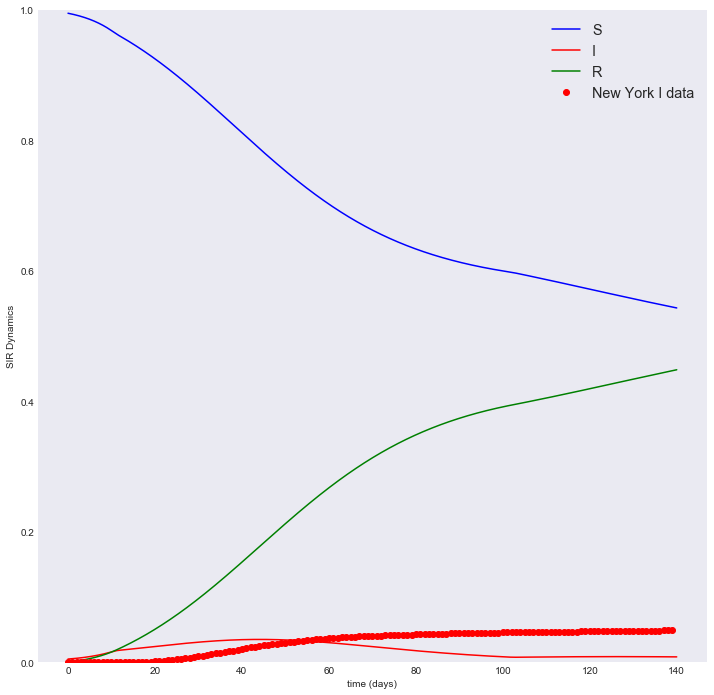

In [12]:
nu=result.x[3]
rho = result.x[4]
beta_S=result.x[0]
beta_A = result.x[1]
gamma= result.x[2]
q = result.x[5]
p = result.x[6]
params = ODE_models.get_params(beta_S=beta_S, beta_A= beta_A, gamma=gamma, nu = nu, rho=rho, q = q, p =p)


fin_time = 140

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

sim_system = odeint(ODE_models.SIRan_system,initial_stateny, timeny, args=(params,))

S = sim_system[:,0]+sim_system[:,1]
I = sim_system[:,2]+sim_system[:,3]+sim_system[:,4]
R = sim_system[:,5]+sim_system[:,6]+sim_system[:,7]

S_curve, = ax.plot(timeny, S, '-b', label='S')
I_curve, = ax.plot(timeny, I, '-r', label='I')
R_curve, = ax.plot(timeny, R, '-g', label='R')
plt.plot(timeobsny,yobsny, color= 'red',marker='o', linestyle='none', label='New York I data')

ax.set(xlabel='time (days)', ylabel='SIR Dynamics')
ax.set_ylim((0,1))
#ax.set_xlim((0,fin_time))
ax.grid()
ax.legend(loc='best',fontsize='x-large')

In [8]:
#California
yobsca = cumulativeca/Nca
r_californiaTSV = '../../california.tsv'
w_californiaTSV = '../../california.tsv'
tsv_read = pd.read_csv("california.tsv", sep='\t')
cumulativeca = tsv_read['confirmed'] #is this what I want?
california_pop = 39.51e6
Nca = california_pop
Sn_0  = 1-(Sa_0+yobsca[1]/Nca)
Sa_0  = 0.005
IS_0  = yobsca[1]/Nca
IAn_0 = 0
IAa_0 = 0
RS_0  = 0
RAn_0 = 0
RAa_0 = 0
M_0   = 0.01
# Simulate the ODE
initial_state = np.array([Sn_0,Sa_0,IS_0,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
time = np.arange(0,176,.001)
timeobs = np.arange(0,176,1)
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))

y =1-(sim_system[:,0]+sim_system[:,1]) #take the integral of this from start to current time
    
yobsca = cumulativeca/Nca
plt.plot(timeobs,yobsca, marker='o', linestyle='none')
plt.plot(time, y, color='C0', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.title('California Cumulative')
plt.show()


NameError: name 'cumulativeca' is not defined